In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


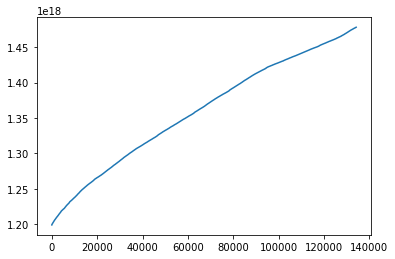

In [4]:
# Убедимся, что данные отсортированны по признаку published
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

In [5]:
pd.DataFrame.corr(train_df)

# В traind_df нет признаков, корреляция между которыми больше 0.9

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


In [8]:
train_df.published.value_counts().idxmax()

'2011-06-14 15:52:00'

Разбиение на train/valid

In [6]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [7]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [8]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

Применение TfidfVectorizer

In [9]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range = (1, 3))

In [10]:
X_train_title = vectorizer_title.fit_transform(X_train['title'])

In [11]:
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [12]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

In [43]:
X_train_title.shape # Нашли размер полученного словаря

(93895, 50624)

In [14]:
vectorizer_title.vocabulary_['python'] # Нашли в словаре индекс термина 'python'

9065

# Инициализация

In [45]:
vectorizer_title_ch = TfidfVectorizer(analyzer = 'char')

In [46]:
X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [53]:
X_train_title_ch.shape # Нашли размер полученного словаря

(93895, 218)

In [48]:
vectorizer_title_ch.vocabulary_

{'н': 133,
 'о': 134,
 'в': 122,
 'г': 123,
 'д': 124,
 'и': 128,
 'й': 129,
 ' ': 0,
 'п': 135,
 'а': 120,
 'р': 136,
 'к': 130,
 'б': 121,
 'л': 131,
 'е': 125,
 'м': 132,
 '—': 170,
 'w': 61,
 'o': 53,
 'r': 56,
 'd': 42,
 'p': 54,
 'e': 43,
 's': 57,
 '2': 18,
 '.': 14,
 '3': 19,
 'с': 137,
 'у': 139,
 'ш': 144,
 'я': 151,
 'ц': 142,
 ',': 12,
 'т': 138,
 'ж': 126,
 'ф': 140,
 'ь': 148,
 'ч': 143,
 'i': 47,
 'h': 46,
 'n': 52,
 'm': 51,
 'b': 40,
 'l': 50,
 '0': 16,
 'щ': 145,
 'k': 49,
 'v': 60,
 'a': 39,
 'u': 59,
 ':': 26,
 'c': 41,
 'з': 127,
 'ы': 147,
 '«': 76,
 '»': 85,
 'х': 141,
 'j': 48,
 '?': 31,
 't': 58,
 '-': 13,
 '1': 17,
 '8': 24,
 '!': 1,
 '9': 25,
 '5': 21,
 '7': 23,
 'q': 55,
 'y': 63,
 'x': 62,
 'g': 45,
 'ю': 150,
 'ъ': 146,
 '4': 20,
 '=': 29,
 '(': 8,
 ')': 9,
 '+': 11,
 'f': 44,
 '…': 178,
 'э': 149,
 '6': 22,
 'z': 64,
 '/': 15,
 '$': 4,
 'ё': 152,
 "'": 7,
 '№': 187,
 '–': 169,
 '[': 33,
 ']': 35,
 '_': 37,
 '\xa0': 71,
 '*': 10,
 '%': 5,
 '{': 65,
 '}': 6

# Работа с категориальными признаками

In [54]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]                           # Для обработки категориальных признаков 'author', 'flow', 'domain' 
                                             # мы будем использовать DictVectorizer из sklearn
                                             # Рассмотрим как он работает на примере первых пяти строк
                                  
                                       

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [55]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [56]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [57]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [58]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [59]:
dict_vect_matrix.shape

(5, 9)

In [60]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique())) 

author 4
flow 3
domain 2


In [61]:
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

# Инициализируем DictVectorizer с параметрами по умолчанию.

In [63]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats])
X_valid_feats = vectorizer_feats.transform(X_valid[feats])
X_test_feats = vectorizer_feats.transform(X_test[feats])

AttributeError: 'str' object has no attribute 'items'